In [1]:
#ADDITIONAL DEPENDENCIES
# !pip install triangle
# !pip install rasterio
# !pip install geopy
# !pip install osmnx

In [1]:
def plot_shortest_paths(assets, graph, shortest_paths, colors):
    from lonboard import Map, PathLayer, ScatterplotLayer
    layers_assets=[]
    # Generate od layer for visualization
    od_geoms=[attr['geometry'] for u,attr in graph.nodes(data=True) if 'name' in attr.keys()]
    od_geoms_gdf=gpd.GeoDataFrame(geometry=od_geoms).set_crs(epsg=3857).to_crs(4326)
    
    layer_od = ScatterplotLayer.from_geopandas(od_geoms_gdf, get_fill_color=colors['red_danger'], get_radius=100, opacity=0.5, auto_highlight=False)
    # Create layer for assets for visualization
    layer_assets = PathLayer.from_geopandas(assets.drop(columns=['other_tags']), get_width=5, get_color=colors['grey_400'], auto_highlight=True, )
    layers_assets.append(layer_assets)
    # layer_shortest_path_assets = PathLayer.from_geopandas(assets_sps.drop(columns=['buffered', 'other_tags']), get_width=80, get_color=colors['black'], auto_highlight=True)
    if shortest_paths is not None:
        shortest_paths_geoms = []
        for od,(path,demand) in shortest_paths.items():
            for u in range(len(path)-1):
                edge = graph.get_edge_data(path[u], path[u+1])
                if edge is not None:
                    for i in range(len(edge)):
                        edge_data = edge[i]
                        edge_geom = edge_data['geometry']
                        shortest_paths_geoms.append((od,demand, edge_geom))
                    
        shortest_paths_gdf = gpd.GeoDataFrame(shortest_paths_geoms, columns=['od','demand', 'geometry']).set_crs(epsg=3857)
        layers_sps = PathLayer.from_geopandas(shortest_paths_gdf, get_width=8, get_color=colors['black'], auto_highlight=True)
        layers_assets.append(layers_sps)
    
    layers=[]
    if layer_assets is not None:
        layers.extend(layers_assets)
    else:
        print('No asset layer')
    Voyager = 'https://basemaps.cartocdn.com/gl/voyager-gl-style/style.json'

    if layer_od is not None:
        layers.append(layer_od)
    else:
        print('No od layer')
    m = Map(layers, show_tooltip=True, basemap_style=Voyager, view_state={"longitude": 7.91, "latitude": 49.91, "zoom": 11})


    return m


In [2]:
import sys
import os
sys.path.append(r'C:\repos\snkit\src')
sys.path.append(r'C:\repos')
sys.path.append(r'C:\repos\ra2ce')
sys.path.append(r'C:\repos\ra2ce_multi_network')
from ci_adapt_utilities import *
# from ci_adapt_classes import *
from ra2ce_multi_network.simplify_rail import *
from ra2ce_multi_network.simplify_rail import _merge_edges, _network_to_nx
import networkx as nx
import pandas as pd
# import re
from math import ceil
import ast
# from pyproj import Transformer
# from shapely.geometry import Point
import warnings
from shapely import make_valid

In [3]:
# Load configuration with ini file (created running config.py)
config_file=r'C:\repos\ci_adapt\config_ci_adapt.ini'
config = configparser.ConfigParser()
config.read(config_file)

# Set paths and data sources
p = Path('..')
hazard_type = config.get('DEFAULT', 'hazard_type')
infra_type = config.get('DEFAULT', 'infra_type')
country_code = config.get('DEFAULT', 'country_code')
country_name = config.get('DEFAULT', 'country_name')
hazard_data_subfolders = config.get('DEFAULT', 'hazard_data_subfolders')
asset_data = config.get('DEFAULT', 'asset_data')
vulnerability_data = config.get('DEFAULT', 'vulnerability_data')
data_path = Path(pathlib.Path.home().parts[0]) / 'Data'
interim_data_path = data_path / 'interim' / 'indirect_damages'

# MIRACA color scheme
color_string = config.get('DEFAULT', 'miraca_colors')
miraca_colors = ast.literal_eval(color_string)

In [4]:
# Define costs for different transport modes
average_train_load_tons = (896+1344+2160+1344+896+896+1344+1512+896+390)/10 # in Tons per train. Source: Kennisinstituut voor Mobiliteitsbeleid. 2023. Cost Figures for Freight Transport – final report
average_train_cost_per_ton_km = (0.014+0.018+0.047+0.045)/4 # in Euros per ton per km. Source: Kennisinstituut voor Mobiliteitsbeleid. 2023. Cost Figures for Freight Transport – final report
average_road_cost_per_ton_km = (0.395+0.375+0.246+0.203+0.138+0.153+0.125+0.103+0.122+0.099)/10 # in Euros per ton per km. Source: Kennisinstituut voor Mobiliteitsbeleid. 2023. Cost Figures for Freight Transport – final report

In [5]:
# Read exposure data (OSM, OpenStreetMap contributors (2024) / osm-flex)
assets_path = data_path / asset_data
assets=preprocess_assets(assets_path)
print(f"{len(assets)} railway freight assets found.")
assets_4326=assets.to_crs(4326)
assets_4326['geometry']=assets_4326['geometry'].make_valid()

47210 railway freight assets found.


In [6]:
assets_4326.head(3)

,osm_id,asset,name,gauge,electrified,voltage,bridge,maxspeed,service,tunnel,other_tags,railway:traffic_mode,usage,geometry
0,3568324,rail,None,1435,contact_line,15000,yes,None,None,None,"""detail""=>""track"",""frequency""=>""16.7"",""layer""=...",None,"""main""","LINESTRING (8.62626 49.81501, 8.62621 49.81489)"
1,3568326,rail,None,1435,contact_line,15000,yes,160,None,None,"""frequency""=>""16.7"",""layer""=>""1"",""level""=>""1"",...",None,"""main""","LINESTRING (8.60882 49.72625, 8.60886 49.72606)"
2,3568327,rail,None,1435,contact_line,15000,None,160,None,None,"""frequency""=>""16.7"",""operator""=>""DB Netz"",""pas...",None,"""main""","LINESTRING (8.61315 49.70201, 8.61323 49.70154..."


In [7]:
route_data_source=r'C:\Data\input\traffic\NET_SEGMENTS_EU_EFTA_Filtered_0.xlsx'
# route_data_source=r'C:\Data\input\traffic\test_seg.xlsx'
route_data=prepare_route_data(route_data_source, assets)
route_data.head(3)

,From,To,From_Latitude,From_Longitude,To_Latitude,To_Longitude,goods,Country,geometry_from,geometry_to
3185,Köln Hbf,Köln-Ehrenfeld Pbf,50.944122,6.960036,50.952471,6.925596,1.0,DE,POINT (774787.7024959939 6611415.535985327),POINT (770953.8479898049 6612890.651068159)
3187,Gummersbach-Dieringhausen,Gummersbach,50.986476,7.542404,51.024612,7.567257,1.0,DE,POINT (839616.5503732515 6618901.841123925),POINT (842383.2159793434 6625648.457596265)
3188,Wemmetsweiler Kurve Einmündung,Wemmetsweiler Kurve,49.367432,7.067455,49.364374,7.070906,1.0,DE,POINT (786745.4918043753 6337438.538431248),POINT (787129.6553671028 6336915.808943185)


In [8]:
# with warnings.catch_warnings():
#     warnings.simplefilter("ignore")
    #Source: Asgarpour/snkit
    # Create a railway networks with possible terminal nodes. This returns a complex network, as includes the rail tracks with the highest level of detail.
    # complex_rail_network = create_network_from_gdf(network_gdf=assets)
net=Network(edges=assets_4326)
net=add_endpoints(network=net)
net=link_nodes_to_edges_within(network=net, distance=0.0000014)
net=add_ids(network=net)
net=add_topology(network=net)
net.set_crs(4326)
net.edges=net.edges.to_crs(3857)
net.nodes=net.nodes.to_crs(3857)


c:\Users\peregrin\AppData\Local\anaconda3\envs\ci_adapt_env\Lib\site-packages\shapely\linear.py:90: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)
c:\Users\peregrin\AppData\Local\anaconda3\envs\ci_adapt_env\Lib\site-packages\shapely\linear.py:90: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)
c:\Users\peregrin\AppData\Local\anaconda3\envs\ci_adapt_env\Lib\site-packages\shapely\linear.py:90: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)
c:\Users\peregrin\AppData\Local\anaconda3\envs\ci_adapt_env\Lib\site-packages\shapely\linear.py:90: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)
c:\Users\peregrin\AppData\Local\anaconda3\envs\ci_adapt_env\Lib\site-packages\shapely\linear.py:90: RuntimeWarning: invalid value encountered in line_locate_point
  return 

In [9]:
complex_rail_network=net

with warnings.catch_warnings():
    try:
        warnings.simplefilter("ignore")
        merged_rail_network = merge_edges(network=complex_rail_network, excluded_edge_types=['bridge', 'tunnel']) #Must add network= to pass excluded_edge_types as a keyword argument

        # Number of nodes and edges reduced
        print(f"Difference in node counts: {complex_rail_network.nodes.shape[0] - merged_rail_network.nodes.shape[0]}")
        print(f"Difference in node counts %: {round(100*(complex_rail_network.nodes.shape[0] - merged_rail_network.nodes.shape[0])/complex_rail_network.nodes.shape[0], 0)}")
        print(f"Difference in edge counts: {complex_rail_network.edges.shape[0] - merged_rail_network.edges.shape[0]}")
        print(f"Difference in edge counts %: {round(100*(complex_rail_network.edges.shape[0] - merged_rail_network.edges.shape[0])/complex_rail_network.edges.shape[0], 0)}")
    except Exception as e:
        print(f'Exception: {e}')
        print('Skipping simplification step.')
        merged_rail_network=complex_rail_network
    

Exception: invalid literal for int() with base 10: 'node_9999'
Skipping simplification step.


In [10]:
# Create graph from network
merged_rail_graph = _network_to_nx(merged_rail_network)

# Create a MultiDiGraph from the graph
graph_0=nx.MultiDiGraph(merged_rail_graph)


In [11]:
for u,v,k,attr in graph_0.edges(keys=True, data=True):
    if type(attr['osm_id'])==type(float()):
        graph_0[u][v][k]['osm_id'] = ''


In [12]:
# Set weights for edges
graph_0 = set_edge_weights(assets, graph_0)

In [11]:
# load graph and shortest paths
if os.path.exists(interim_data_path / 'graph_0.pkl'):
    graph_0 = pickle.load(open(interim_data_path / 'graph_0.pkl','rb'))
    shortest_paths = pickle.load(open(interim_data_path / 'shortest_paths.pkl', 'rb'))
    disrupted_edges_by_basin = pickle.load(open(interim_data_path / 'disrupted_edges_by_basin.pkl', 'rb'))
    disrupted_shortest_paths = pickle.load(open(interim_data_path / 'disrupted_shortest_paths.pkl', 'rb'))
    print('Data loaded from pickle files.')

Data loaded from pickle files.


In [13]:
# Set capacities for flow model
graph_0, shortest_paths = set_edge_capacities(graph_0, route_data, simplified=True)

Possible terminals: 53289


Finding shortest paths between origin-destination pairs:  49%|████▉     | 531/1086 [12:34<13:13,  1.43s/it]

Name mismatch: Limburg (Lahn) HE/RP 3710 vs Limburg (Lahn) HE/RP 3730, updating to Limburg (Lahn) HE/RP 3730


Finding shortest paths between origin-destination pairs:  74%|███████▍  | 808/1086 [19:09<06:42,  1.45s/it]

Name mismatch: Saarhölzbach - Taben vs Saarhölzbach SL/RP, updating to Saarhölzbach SL/RP


Finding shortest paths between origin-destination pairs:  84%|████████▎ | 909/1086 [21:34<04:13,  1.43s/it]

Name mismatch: Aschaffenburg Hbf vs Mainaschaff Steinerts, updating to Mainaschaff Steinerts


Finding shortest paths between origin-destination pairs:  84%|████████▍ | 914/1086 [21:42<04:05,  1.43s/it]

Name mismatch: Mainaschaff Steinerts vs Aschaffenburg Hbf, updating to Aschaffenburg Hbf


Finding shortest paths between origin-destination pairs:  85%|████████▌ | 927/1086 [22:00<03:50,  1.45s/it]

Name mismatch: Aschaffenburg Hbf vs Mainaschaff Steinerts, updating to Mainaschaff Steinerts


Finding shortest paths between origin-destination pairs:  86%|████████▋ | 939/1086 [22:18<03:36,  1.47s/it]

Name mismatch: Ludwigshafen (Rhein) Hbf RP/BW vs Ludwigshafen 3401 LGr, updating to Ludwigshafen 3401 LGr


Finding shortest paths between origin-destination pairs:  90%|████████▉ | 974/1086 [23:10<02:36,  1.40s/it]

Name mismatch: Ludwigshafen 3401 LGr vs Ludwigshafen (Rhein) Hbf RP/BW, updating to Ludwigshafen (Rhein) Hbf RP/BW


Finding shortest paths between origin-destination pairs:  90%|████████▉ | 976/1086 [23:12<02:34,  1.40s/it]

Name mismatch: Aschaffenburg Süd vs Babenhausen (Hess) HE/BY, updating to Babenhausen (Hess) HE/BY


Finding shortest paths between origin-destination pairs:  90%|█████████ | 979/1086 [23:17<02:28,  1.39s/it]

Name mismatch: Koblenz Horchheimer Brücke vs Niederlahnstein Streckenw 2324/3507, updating to Niederlahnstein Streckenw 2324/3507


Finding shortest paths between origin-destination pairs:  90%|█████████ | 981/1086 [23:19<02:26,  1.39s/it]

Name mismatch: Mainaschaff Steinerts vs Aschaffenburg Hbf, updating to Aschaffenburg Hbf


Finding shortest paths between origin-destination pairs:  91%|█████████ | 988/1086 [23:29<02:16,  1.39s/it]

Name mismatch: Mannheim-Waldhof BW/HE vs Mannheim-Waldhof - Lampertheim, updating to Mannheim-Waldhof - Lampertheim


Finding shortest paths between origin-destination pairs:  92%|█████████▏| 996/1086 [23:40<02:06,  1.40s/it]

Name mismatch: Ludwigshafen (Rhein) Hbf RP/BW vs Ludwigshafen 3401 LGr, updating to Ludwigshafen 3401 LGr


Finding shortest paths between origin-destination pairs:  93%|█████████▎| 1014/1086 [24:06<01:41,  1.41s/it]

Name mismatch: Bonn - Rolandseck vs Bonn Neuer Weg NRW/RP, updating to Bonn Neuer Weg NRW/RP


Finding shortest paths between origin-destination pairs:  94%|█████████▎| 1018/1086 [24:11<01:36,  1.42s/it]

Name mismatch: Bonn Neuer Weg NRW/RP vs Bonn - Rolandseck, updating to Bonn - Rolandseck


Finding shortest paths between origin-destination pairs:  94%|█████████▍| 1019/1086 [24:13<01:36,  1.44s/it]

Name mismatch: Bonn - Rolandseck vs Bonn Neuer Weg NRW/RP, updating to Bonn Neuer Weg NRW/RP


Finding shortest paths between origin-destination pairs:  95%|█████████▍| 1027/1086 [24:24<01:22,  1.40s/it]

Name mismatch: Heppenheim - Laudenbach vs Laudenbach (Bergstr) BW/HE, updating to Laudenbach (Bergstr) BW/HE


Finding shortest paths between origin-destination pairs:  96%|█████████▌| 1043/1086 [24:47<01:01,  1.43s/it]

Name mismatch: Bad Honnef - Unkel vs Bad Honnef NRW/RP, updating to Bad Honnef NRW/RP


Finding shortest paths between origin-destination pairs:  96%|█████████▋| 1046/1086 [24:51<00:57,  1.44s/it]

Name mismatch: Laudenbach (Bergstr) BW/HE vs Heppenheim - Laudenbach, updating to Heppenheim - Laudenbach


Finding shortest paths between origin-destination pairs:  99%|█████████▉| 1074/1086 [25:31<00:16,  1.40s/it]

Name mismatch: Köln Süd vs Köln Süd Abzw, updating to Köln Süd Abzw


Finding shortest paths between origin-destination pairs: 100%|██████████| 1086/1086 [25:48<00:00,  1.43s/it]

Failed to find paths for 28 routes


In [1]:
plot_shortest_paths(assets, graph_0, shortest_paths, miraca_colors)

NameError: name 'plot_shortest_paths' is not defined

In [14]:
# Create initial virtual graph
graph_v0=create_virtual_graph(graph_0)


Max weight: 17100298
Max capacity: 1
Success: only int type values


In [15]:
graph_v=graph_v0.copy()

In [16]:
# Define the baseline return periods 
"""
Return period definitions for Rhineland Palatinate (DERP) based on the report by Rauthe M, et al. (2020):
_H_=10-25y 
_M_=100y
_L_=200y
"""
return_period_dict = {'_H_': 10,'_M_': 100,'_L_': 200}

# Add climate change: calculate the dynamic return periods based on flat increase factors. 
# This value has been catchment-specific with frequency increasing in some regions and decreasing in others. 
# It is reasonable that in the future, the frequency will continue to change differently by catchment.

increase_factor = {
    '_H_': 2,
    '_M_': 6.6,
    '_L_': 9.1
} # https://hess.copernicus.org/preprints/hess-2016-65/hess-2016-65-manuscript-version2.pdf 

num_years = 100
return_periods = calculate_dynamic_return_periods(return_period_dict, num_years, increase_factor)

In [17]:
if 'collect_output' not in locals():
    collect_output_path = f'C:/Data/interim/collected_flood_runs/sample_collected_run.pkl'
    with open(collect_output_path, 'rb') as f:
        collect_output = pickle.load(f)

In [18]:
# Loop through the event files and calculate the economic impact of each event
disrupted_asset_lengths={}
disrupted_shortest_paths={}
event_impacts={}
disrupted_edges_by_basin={}

for hazard_map, asset_dict in collect_output.items():
    disrupted_assets = [key for key in asset_dict.keys()]
    disrupted_osm_ids = [
        assets.loc[asset_index]['osm_id'] 
        for asset_index in disrupted_assets 
        if asset_index in assets.index and (
            (assets.loc[asset_index]['bridge'] != 'yes') 
            and (assets.loc[asset_index]['tunnel'] != 'yes')
            and (assets.loc[asset_index]['osm_id'] is not None)
            )
        ]
    
    if len(disrupted_osm_ids)==0:
        continue

    disrupted_edges=[]
    
    for u,v,attr in graph_0.edges(data=True):
        if 'osm_id' not in attr: 
            continue
        if attr['bridge']=='yes' or attr['tunnel']=='yes':
            continue
        matching_ids=[osm_id for osm_id in attr['osm_id'].split('; ') if osm_id in disrupted_osm_ids]
        if len(matching_ids)>0:
            disrupted_edges.append((u,v))
            
    print(f'Disrupted edges: {len(disrupted_edges)}')

    # If there are no disrupted edges in the event, move to next event
    if len(disrupted_edges)==0:
        continue
    
    disrupted_edges_by_basin[hazard_map]=disrupted_edges
    disrupted_shortest_paths[hazard_map]=calculate_new_paths(graph_v0, shortest_paths, disrupted_edges)

    if disrupted_shortest_paths[hazard_map] == {}: # No disrupted paths, no economic impact
        print(f'No shortest paths disrupted for {hazard_map}. No economic impact.')
        continue


    print('Calculating economic impact...')
    impact=calculate_economic_impact_shortest_paths(hazard_map, graph_v, shortest_paths, disrupted_shortest_paths[hazard_map], average_train_load_tons, average_train_cost_per_ton_km, average_road_cost_per_ton_km)
    event_impacts[hazard_map]=impact
    print(hazard_map, impact)

Disrupted edges: 6
Calculating economic impact...
flood_DERP_RW_H_4326_2080410170 467036.2736560443
Disrupted edges: 14
Calculating economic impact...
flood_DERP_RW_H_4326_2080410430 189684.14263829618
Disrupted edges: 8
Calculating economic impact...
flood_DERP_RW_H_4326_2080410540 1289636.8322893078
Disrupted edges: 22
Calculating economic impact...
flood_DERP_RW_H_4326_2080411370 6050405.820182627
Disrupted edges: 34
Calculating economic impact...
flood_DERP_RW_H_4326_2080416210 16468948.724179069
Disrupted edges: 26
Calculating economic impact...
flood_DERP_RW_H_4326_2080418600 36889.72664524174
Disrupted edges: 8
Calculating economic impact...
flood_DERP_RW_H_4326_2080418880 9035420.177934907
Disrupted edges: 24
No shortest paths disrupted for flood_DERP_RW_H_4326_2080419180. No economic impact.
Disrupted edges: 58
Calculating economic impact...
flood_DERP_RW_H_4326_2080420240 5109340.3360396605
Disrupted edges: 20
Calculating economic impact...
flood_DERP_RW_H_4326_2080421680 440

In [19]:
#now repeat collecting all the disrupted edges accross all maps with the same return period

all_disrupted_edges={}
all_disrupted_shortest_paths={}
full_flood_event={}

haz_map_names=['flood_DERP_RW_H', 'flood_DERP_RW_M', 'flood_DERP_RW_L']

for haz_map in haz_map_names:
    all_disrupted_edges[haz_map]=[]
    for key, value in disrupted_edges_by_basin.items():
        if haz_map in key:
            all_disrupted_edges[haz_map].extend(value)
    all_disrupted_edges[haz_map]=list(set(all_disrupted_edges[haz_map]))
    print(f'Number of disrupted edges for {haz_map}: ', len(all_disrupted_edges[haz_map]))
    print('Calculating shortest paths for: ', haz_map)
    all_disrupted_shortest_paths[haz_map]=calculate_new_paths(graph_v0, shortest_paths, all_disrupted_edges[haz_map])

    if all_disrupted_shortest_paths[haz_map] == {}: # No disrupted paths, no economic impact
        print(f'No shortest paths disrupted for {haz_map}. No economic impact.')
        continue

    print('Calculating economic impact...')    
    impact=calculate_economic_impact_shortest_paths(haz_map, graph_v, shortest_paths, all_disrupted_shortest_paths[haz_map], average_train_load_tons, average_train_cost_per_ton_km, average_road_cost_per_ton_km)
    print(f'Impact for {haz_map} in M Eur: {impact/1e6 :.2f}')
    full_flood_event[haz_map]=impact

# save the data
with open(interim_data_path / 'all_disrupted_edges.pkl', 'wb') as f:
    pickle.dump(all_disrupted_edges, f)
with open(interim_data_path / 'full_flood_event.pkl', 'wb') as f:
    pickle.dump(full_flood_event, f)


Number of disrupted edges for flood_DERP_RW_H:  702
Calculating shortest paths for:  flood_DERP_RW_H
Calculating economic impact...
Impact for flood_DERP_RW_H in M Eur: 69.23
Number of disrupted edges for flood_DERP_RW_M:  1842
Calculating shortest paths for:  flood_DERP_RW_M
Calculating economic impact...
Impact for flood_DERP_RW_M in M Eur: 155.22
Number of disrupted edges for flood_DERP_RW_L:  8398
Calculating shortest paths for:  flood_DERP_RW_L
Calculating economic impact...
Impact for flood_DERP_RW_L in M Eur: 1102.81


In [20]:
files = [file for file in os.listdir('C:/Data/interim/collected_flood_runs') if file.endswith('.pkl') and file.startswith('overlay')]
basins_list=list(set([int(file.split('.')[0].split('_')[-1]) for file in files]))
basin_dict = {}
for basin in basins_list:
    basin_dict[basin] = {}
    for key in event_impacts.keys():
        if not str(basin) in key:
            continue
        if str(basin) in key:
            basin_dict[basin][key.split('_RW')[-1][0:3]] = event_impacts[key]


for rp in return_period_dict.keys():
    # add rp as a key to all nested dictionaries with 0 as a value if the rp is not already a key
    for basin in basin_dict.keys():
        if rp not in basin_dict[basin].keys():
            basin_dict[basin][rp] = 0

basin_dict
          

{2080428160: {'_H_': 0, '_M_': 0, '_L_': 0},
 2080438400: {'_H_': 211198.59597096598,
  '_L_': 2515588.981468116,
  '_M_': 503117.79629362316},
 2080432510: {'_L_': 394155.7286440181, '_M_': 23068.4001920928, '_H_': 0},
 2080431110: {'_L_': 695534.8955672166, '_M_': 1415.4358985765234, '_H_': 0},
 2080431750: {'_H_': 0, '_M_': 0, '_L_': 0},
 2080410760: {'_H_': 0, '_M_': 0, '_L_': 0},
 2080436870: {'_L_': 60041650.7749748, '_H_': 0, '_M_': 0},
 2080421770: {'_H_': 10752834.934709515,
  '_L_': 323394013.9214329,
  '_M_': 37736285.70972274},
 2080438410: {'_H_': 21192.971208141622,
  '_L_': 211929.71208141625,
  '_M_': 42385.942416283244},
 2080446220: {'_H_': 997307.1277600857,
  '_L_': 9973071.277600856,
  '_M_': 1994614.2555201715},
 2080420240: {'_H_': 5109340.3360396605,
  '_L_': 82149542.12110929,
  '_M_': 10218680.672079321},
 2080432400: {'_H_': 4352.528231356173,
  '_L_': 43525.28231356172,
  '_M_': 8705.056462712346},
 2080418720: {'_L_': 60504058.201826274, '_H_': 0, '_M_': 0}

In [21]:

aggregated_df_by_basin = {}
ead_by_ts_by_basin = {}

for basin, damage_dict in basin_dict.items():
    if len(damage_dict) == 0:
        continue

    aggregated_df_by_basin[basin] = pd.DataFrame.from_dict(damage_dict, orient='index', columns=['Total indirect damage'])
    aggregated_df_by_basin[basin]['Return Period'] = [return_periods[index] for index in aggregated_df_by_basin[basin].index]
    probabilities = [[1 / rp for rp in ts] for ts in aggregated_df_by_basin[basin]['Return Period']]
    aggregated_df_by_basin[basin]['Probability'] = probabilities
    dmgs = []

    for ts in range(len(probabilities[0])):    
        dmgs_m = []

        for rp in range(len(probabilities)-1):
            d_rp= probabilities[rp][ts] - probabilities[rp + 1][ts]
            trap_damage_m = 0.5 * (aggregated_df_by_basin[basin]['Total indirect damage'].iloc[rp] + aggregated_df_by_basin[basin]['Total indirect damage'].iloc[rp + 1])
            dmgs_m.append(d_rp * trap_damage_m)
        
        # Add the portion of damages corresponding to the tails of the distribution
        d0_rp = probabilities[-1][ts]
        damage_m0 = max(aggregated_df_by_basin[basin]['Total indirect damage'])
        dmgs_m.append(d0_rp * damage_m0)

        d_end_rp = (1/4)-probabilities[0][ts]
        damage_m_end = 0.5 * min(aggregated_df_by_basin[basin]['Total indirect damage'])

        dmgs_m.append(d_end_rp * damage_m_end)

        dmgs.append((sum(dmgs_m)))
    
    ead_by_ts_by_basin[basin] = pd.DataFrame(dmgs, columns=['Total indirect damage'])


In [22]:
ead_by_ts_by_basin[2080441280]

,Total indirect damage
0,4.784331e+06
1,4.851676e+06
2,4.919022e+06
3,4.986368e+06
4,5.053714e+06
...,...
96,1.124952e+07
97,1.131687e+07
98,1.138421e+07
99,1.145156e+07


In [23]:
# Find total damages by basin over the 100 y period
total_damages_by_basin = {basin: ead_by_ts_by_basin[basin].values.sum() for basin in ead_by_ts_by_basin.keys()}
total_damages_by_basin


{2080428160: 0.0,
 2080438400: 25956134.483415708,
 2080432510: 5572344.231516046,
 2080431110: 10080599.067728447,
 2080431750: 0.0,
 2080410760: 0.0,
 2080436870: -147815039.0016411,
 2080421770: 3168048649.6133223,
 2080438410: 2225307.0119186877,
 2080446220: 104719367.69245549,
 2080420240: 831338574.0265847,
 2080432400: 457024.71341488976,
 2080418720: -148953428.28562105,
 2080430240: 297137438.7976597,
 2080410660: 0.0,
 2080434470: 255787541.7392105,
 2080418600: 584438525.9568775,
 2080433960: 0.0,
 2080410540: 153213565.11268488,
 2080431660: 0.0,
 2080421680: 857208348.8763474,
 2080428080: 0.0,
 2080436660: 0.0,
 2080410170: 49039801.18596616,
 2080434490: 1030606.6858875183,
 2080410430: 19917238.05582421,
 2080418880: 948738318.9510436,
 2080441280: 823313346.7925214,
 2080434630: 233232476.5514753,
 2080416200: 0.0,
 2080418890: 4319780451.6917305,
 2080429770: 7303264.204621082,
 2080433740: 0.0,
 2080448120: 1229765.9188739224,
 2080416210: 2158780601.95992,
 2080428

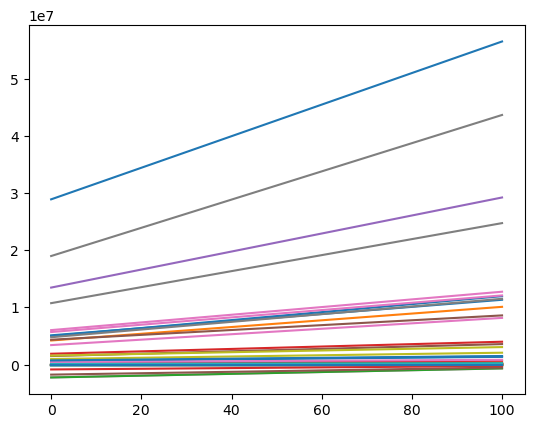

In [24]:
#plot the EAD for each basin    
from matplotlib import pyplot as plt
for basin, ead_df in ead_by_ts_by_basin.items():
    plt.plot(ead_df, label=basin)
        

In [25]:
import geopandas as gpd
# from lonboard import viz  # Assuming 'lonboard' is a correct module name; if not, correct as necessary

def georeference_damages(gdf, damages):
    # Initialize 'damage' column to 0
    gdf['damage'] = 0
    # Vectorized operation to map damages based on 'HYBAS_ID'
    damage_map = {key: value for key, value in damages.items() if key in gdf['HYBAS_ID'].tolist()}
    gdf['damage'] = gdf['HYBAS_ID'].map(damage_map).fillna(0)
    return gdf

# Load basins GeoDataFrame
basins = gpd.read_file(r'c:\Data\Floods\basins\hybas_eu_lev01-12_v1c\hybas_eu_lev08_v1c_valid.shp')

# Assuming 'basins_list' is a predefined list of 'HYBAS_ID's to filter by
basins_filtered = basins[basins['HYBAS_ID'].isin(basins_list)]

# Assuming 'ead_df' is a dictionary with 'HYBAS_ID' as keys and damage values as values
ead_gdf = georeference_damages(basins_filtered, total_damages_by_basin)
ead_gdf


c:\Users\peregrin\AppData\Local\anaconda3\envs\ci_adapt_env\Lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,HYBAS_ID,NEXT_DOWN,NEXT_SINK,MAIN_BAS,DIST_SINK,DIST_MAIN,SUB_AREA,UP_AREA,PFAF_ID,ENDO,COAST,ORDER,SORT,geometry,damage
6346,2080411370,2080399810,2080023010,2080023010,380.2,380.2,243.7,140600.1,23261091,0,0,1,6347,"POLYGON ((7.10417 50.75000, 7.10417 50.75417, ...",1.794135e+09
6351,2080410660,2080410160,2080023010,2080023010,401.9,401.9,326.1,1562.0,23261085,0,0,2,6352,"POLYGON ((7.72917 50.77083, 7.71758 50.77146, ...",0.000000e+00
6353,2080416210,2080411370,2080023010,2080023010,408.8,408.8,257.2,139454.7,23261093,0,0,1,6354,"POLYGON ((7.27917 50.55417, 7.27917 50.55833, ...",2.158781e+09
6354,2080416200,2080411370,2080023010,2080023010,408.8,408.8,901.7,901.7,23261092,0,0,2,6355,"POLYGON ((6.90833 50.26667, 6.90798 50.26909, ...",0.000000e+00
6357,2080418600,2080416210,2080023010,2080023010,428.5,428.5,737.4,737.6,23261094,0,0,2,6358,"POLYGON ((7.57917 50.54167, 7.57860 50.53946, ...",5.844385e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6431,2080433960,2080436660,2080023010,2080023010,658.3,658.3,885.9,886.0,23262042,0,0,4,6432,"POLYGON ((6.53750 49.87917, 6.53715 49.86841, ...",0.000000e+00
6432,2080434150,2080436660,2080023010,2080023010,658.4,658.4,290.5,3296.4,23262043,0,0,3,6433,"POLYGON ((6.21667 49.68750, 6.21723 49.68971, ...",0.000000e+00
6464,2080451930,2080445670,2080023010,2080023010,738.9,738.9,738.3,1863.4,23262027,0,0,3,6465,"POLYGON ((7.32917 49.23750, 7.32832 49.23418, ...",9.748345e+05
6479,2080447970,2080451930,2080023010,2080023010,781.1,781.1,609.0,609.0,23262029,0,0,3,6480,"POLYGON ((7.59583 49.39583, 7.59668 49.39915, ...",3.065981e+06


In [26]:
# save G and shortest paths to pickle files
pickle.dump(graph_0, open(interim_data_path / 'graph_0.pkl', 'wb'))
pickle.dump(shortest_paths, open(interim_data_path / 'shortest_paths.pkl', 'wb'))
pickle.dump(disrupted_edges_by_basin, open(interim_data_path / 'disrupted_edges_by_basin.pkl', 'wb'))
pickle.dump(disrupted_shortest_paths, open(interim_data_path / 'disrupted_shortest_paths.pkl', 'wb'))
pickle.dump(event_impacts, open(interim_data_path / 'event_impacts.pkl', 'wb'))
pickle.dump(ead_gdf, open(interim_data_path / 'ead_gdf.pkl', 'wb'))
pickle.dump(ead_by_ts_by_basin, open(interim_data_path / 'ead_by_ts_by_basin.pkl', 'wb'))
print('Data saved to pickle files.')


Data saved to pickle files.


In [ ]:
ead_by_ts_by_basin=pickle.load(open(interim_data_path / 'ead_by_ts_by_basin.pkl', 'rb'))

In [ ]:
ead_by_ts_by_basin

{2080430320:      Total indirect damage
 0             2.413722e+06
 1             2.447520e+06
 2             2.481319e+06
 3             2.515118e+06
 4             2.548917e+06
 ..                     ...
 96            5.658409e+06
 97            5.692208e+06
 98            5.726007e+06
 99            5.759806e+06
 100           5.793604e+06
 
 [101 rows x 1 columns]}

In [27]:
# Create visualisation for the basin and the discharge points
from lonboard import Map, PolygonLayer, PathLayer

layer_basin = None#PolygonLayer.from_geopandas(basins_filtered,
    # get_fill_color=miraca_colors['grey_100'],
    # get_line_color=miraca_colors['green_900'], get_line_width=100,
    # auto_highlight=False,
    # filled=False)

# Flood return period: H for frequent(RP10-20), M for 100 year return period (RP100) and L for extreme (RP2000)
return_period_str='L'
basin_vis_str='2080430320'
# Generate flood layers and protection layers for visualization
flood_plot_path=r'Floods\Germany\raw_data\SzenarioSelten\DERP_RW_L.shp'#rf'C:\Data\Floods\Germany\basin_intersections\DERP_RW_L_4326_hybas_intersections\flood_DERP_RW_{return_period_str}_4326_{basin_vis_str}.geojson'
flood_m = data_path / flood_plot_path
flood_gdf=gpd.read_file(flood_m)
layers_flood=[]
f_area_colors = {1:'blue', 3:'green'}
for f_area in flood_gdf.flood_area.unique():
    for f_depth in flood_gdf.depth_class.unique():
        subset_gdf = flood_gdf[(flood_gdf.depth_class==f_depth) & (flood_gdf.flood_area==f_area)]
        if not subset_gdf.empty:
            color_key=f'{f_area_colors[f_area]}_{f_depth}00'
            layers_flood.append(PolygonLayer.from_geopandas(subset_gdf, 
                                                            get_fill_color=miraca_colors[color_key], 
                                                            opacity=0.5, 
                                                            stroked=False))

assets_no_buffer = assets.copy()
#drop the buffered geometry from the assets
assets_no_buffer = assets_no_buffer.drop(columns='buffered')
layer_rail = PathLayer.from_geopandas(assets_no_buffer, width_min_pixels=0.8)

layers=[]
if layer_basin is not None:
    layers.append(layer_basin)
else:
    print('No basin layer')
if layers_flood is not None:
    layers.extend(layers_flood)
else:
    print('No flood layers')
if layer_rail is not None:
    layers.append(layer_rail)
else:
    print('No rail layers')

Voyager = 'https://basemaps.cartocdn.com/gl/voyager-gl-style/style.json'

m = Map(layers, show_tooltip=True, basemap_style=Voyager) 

m


AttributeError: 'GeoDataFrame' object has no attribute 'flood_area'

In [64]:
ead_gdf

,HYBAS_ID,NEXT_DOWN,NEXT_SINK,MAIN_BAS,DIST_SINK,DIST_MAIN,SUB_AREA,UP_AREA,PFAF_ID,ENDO,COAST,ORDER,SORT,geometry,damage
6378,2080430320,2080428500,2080023010,2080023010,511.4,511.4,64.9,4060.3,23263061,0,0,2,6379,"POLYGON ((7.91667 49.88750, 7.91424 49.88785, ...",2.450038e+06


In [31]:
# Visualisation

def get_node_from_spaths(shortest_paths):
    nodes_list = []
    for key in shortest_paths.keys():
        origin, destination = key
        nodes_list.append(origin)
        nodes_list.append(destination)

    nodes_list = list(set(nodes_list))  # Remove duplicates

    return nodes_list

def from_spaths_to_edges(shortest_paths):
    edges_in_paths = []
    for (o, d), (nodes_in_path, demand) in shortest_paths.items():
        if nodes_in_path is None:
            print(f'No path found between {o} and {d}. Cannot ship by train.')
            continue
        
        edges_in_path = [(nodes_in_path[i], nodes_in_path[i+1]) for i in range(len(nodes_in_path)-1)]
        edges_in_paths.extend(edges_in_path)
    return edges_in_paths






In [ ]:
# from shapely.geometry import LineString
# # Round coordinates to 0 decimal places to avoid GEOSException: TopologyException: side location conflict at x, y
# def round_coordinates(line):
#     rounded_coords = []
#     for coord in line.coords:
#         rounded_coords.append((round(coord[0], 0), round(coord[1], 0)))
#     return LineString(rounded_coords)

# geoms=[]
# for geom in assets['geometry']:
#     geoms.append(round_coordinates(geom))

# assets['geometry']=geoms

In [ ]:
# import warnings

# with warnings.catch_warnings():
#     warnings.simplefilter("ignore")
#     #Source: Asgarpour/snkit
#     # Create a railway networks with possible terminal nodes. This returns a complex network, as includes the rail tracks with the highest level of detail.
#     aggregation_range = 0.08 # in km
#     complex_rail_network = get_rail_network_with_terminals(network_gdf=assets, aggregation_range=aggregation_range)
